In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,304508,302263]

with open('pileupInput_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileupInput_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



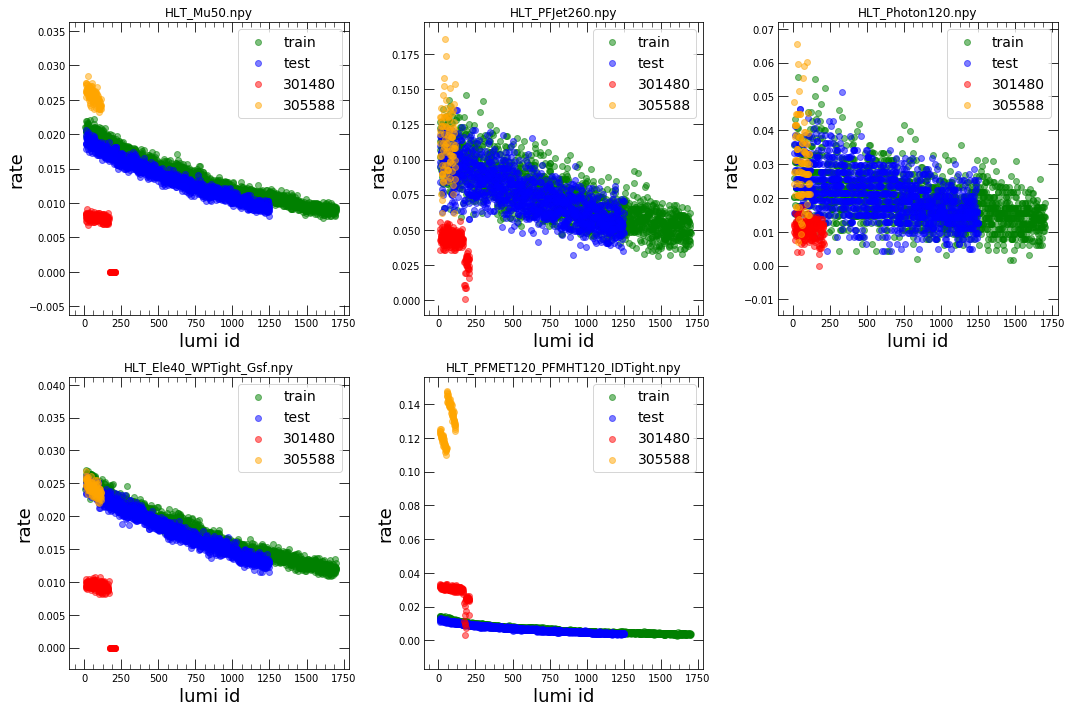

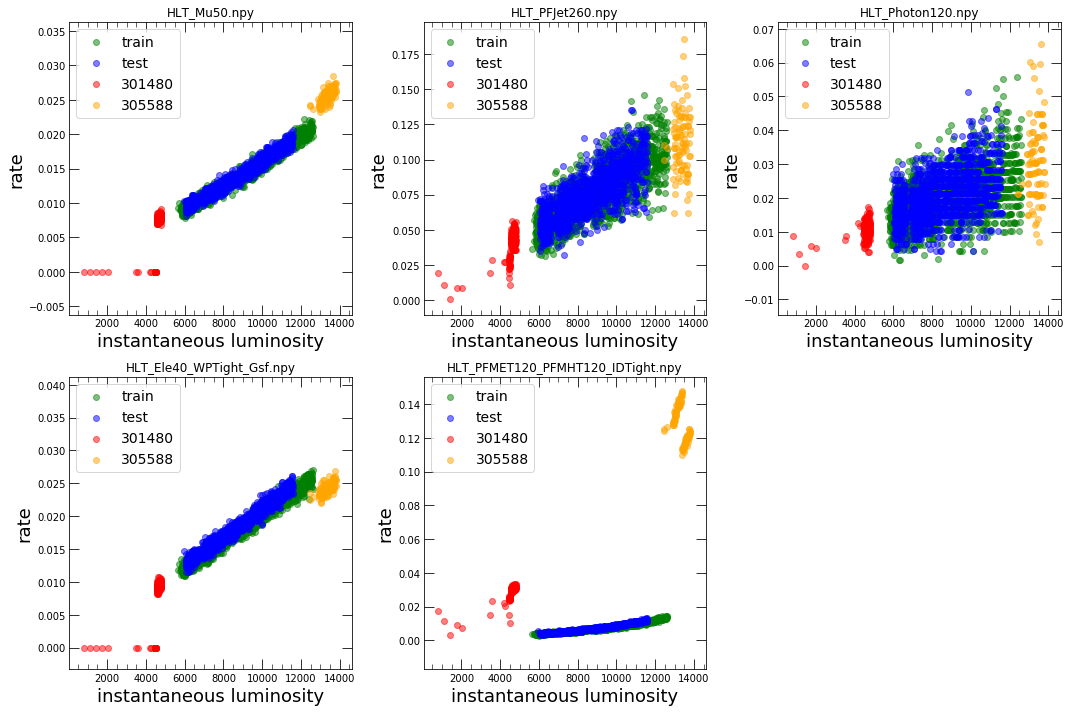

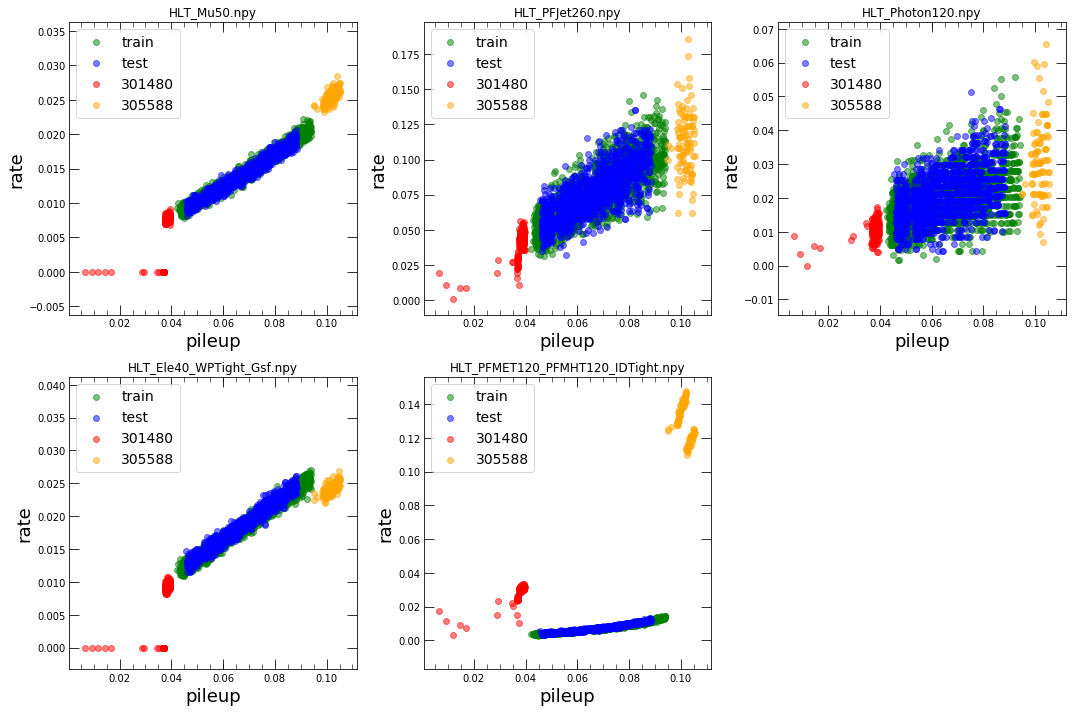

In [6]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [7]:
model_name = "pileupInputReLU"

In [8]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(_input)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 21        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 24        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 1s - loss: 0.3209 - val_loss: 0.3189
Epoch 2/1000
 - 0s - loss: 0.3128 - val_loss: 0.3111
Epoch 3/1000
 - 0s - loss: 0.3052 - val_loss: 0.3032
Epoch 4/1000
 - 0s - loss: 0.2974 - val_loss: 0.2955
Epoch 5/1000
 - 0s - loss: 0.2898 - val_loss: 0.2879
Epoch 6/1000
 - 0s - loss: 0.2825 - val_loss: 0.2805
Epoch 7/1000
 - 0s - loss: 0.2752 - val_loss: 0.2733
Epoch 8/1000
 - 0s - loss: 0.2681 - val_loss: 0.2663
Epoch 9/1000
 - 0s - loss: 0.2612 - val_loss: 0.2594
Epoch 10/1000
 - 0s - loss: 0.2544 - val_loss: 0.2527
Epoch 11/1000
 - 0s - loss: 0.2479 - val_loss: 0.2461
Epoch 12/1000
 - 0s - loss: 0.2414 - val_loss: 0.2397
Epoch 13/1000
 - 0s - loss: 0.2351 - val_loss: 0.2335
Epoch 14/1000
 - 0s - loss: 0.2291 - val_loss: 0.2274
Epoch 15/1000
 - 0s - loss: 0.2231 - val_loss: 0.2215
Epoch 16/1000
 - 0s - loss: 0.2173 - val_loss: 0.2158
Epoch 17/1000
 - 0s - loss: 0.2116 - val_loss: 0.2102
Epoch 18/1000
 - 0s - loss: 0.2062 - val_lo

Epoch 152/1000
 - 0s - loss: 0.0135 - val_loss: 0.0135
Epoch 153/1000
 - 0s - loss: 0.0133 - val_loss: 0.0133
Epoch 154/1000
 - 0s - loss: 0.0131 - val_loss: 0.0131
Epoch 155/1000
 - 0s - loss: 0.0129 - val_loss: 0.0129
Epoch 156/1000
 - 0s - loss: 0.0127 - val_loss: 0.0127
Epoch 157/1000
 - 0s - loss: 0.0125 - val_loss: 0.0125
Epoch 158/1000
 - 0s - loss: 0.0123 - val_loss: 0.0123
Epoch 159/1000
 - 0s - loss: 0.0121 - val_loss: 0.0121
Epoch 160/1000
 - 0s - loss: 0.0120 - val_loss: 0.0120
Epoch 161/1000
 - 0s - loss: 0.0118 - val_loss: 0.0118
Epoch 162/1000
 - 0s - loss: 0.0116 - val_loss: 0.0116
Epoch 163/1000
 - 0s - loss: 0.0114 - val_loss: 0.0114
Epoch 164/1000
 - 0s - loss: 0.0112 - val_loss: 0.0113
Epoch 165/1000
 - 0s - loss: 0.0111 - val_loss: 0.0111
Epoch 166/1000
 - 0s - loss: 0.0109 - val_loss: 0.0109
Epoch 167/1000
 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 168/1000
 - 0s - loss: 0.0106 - val_loss: 0.0106
Epoch 169/1000
 - 0s - loss: 0.0104 - val_loss: 0.0105
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 302/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 303/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 304/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 305/1000
 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 306/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 307/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 308/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 309/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 310/1000
 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 311/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 312/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 313/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 314/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 315/1000
 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 316/1000
 - 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 317/1000
 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 318/1000
 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 319/

Epoch 441/1000
 - 0s - loss: 5.8435e-04 - val_loss: 5.8243e-04
Epoch 442/1000
 - 0s - loss: 5.7987e-04 - val_loss: 5.7796e-04
Epoch 443/1000
 - 0s - loss: 5.7546e-04 - val_loss: 5.7352e-04
Epoch 444/1000
 - 0s - loss: 5.7108e-04 - val_loss: 5.6913e-04
Epoch 445/1000
 - 0s - loss: 5.6677e-04 - val_loss: 5.6477e-04
Epoch 446/1000
 - 0s - loss: 5.6245e-04 - val_loss: 5.6046e-04
Epoch 447/1000
 - 0s - loss: 5.5819e-04 - val_loss: 5.5619e-04
Epoch 448/1000
 - 0s - loss: 5.5397e-04 - val_loss: 5.5195e-04
Epoch 449/1000
 - 0s - loss: 5.4979e-04 - val_loss: 5.4775e-04
Epoch 450/1000
 - 0s - loss: 5.4565e-04 - val_loss: 5.4359e-04
Epoch 451/1000
 - 0s - loss: 5.4154e-04 - val_loss: 5.3947e-04
Epoch 452/1000
 - 0s - loss: 5.3748e-04 - val_loss: 5.3538e-04
Epoch 453/1000
 - 0s - loss: 5.3343e-04 - val_loss: 5.3134e-04
Epoch 454/1000
 - 0s - loss: 5.2946e-04 - val_loss: 5.2732e-04
Epoch 455/1000
 - 0s - loss: 5.2549e-04 - val_loss: 5.2335e-04
Epoch 456/1000
 - 0s - loss: 5.2155e-04 - val_loss: 5.1

Epoch 572/1000
 - 0s - loss: 2.3107e-04 - val_loss: 2.2845e-04
Epoch 573/1000
 - 0s - loss: 2.2955e-04 - val_loss: 2.2692e-04
Epoch 574/1000
 - 0s - loss: 2.2803e-04 - val_loss: 2.2540e-04
Epoch 575/1000
 - 0s - loss: 2.2652e-04 - val_loss: 2.2389e-04
Epoch 576/1000
 - 0s - loss: 2.2501e-04 - val_loss: 2.2239e-04
Epoch 577/1000
 - 0s - loss: 2.2353e-04 - val_loss: 2.2091e-04
Epoch 578/1000
 - 0s - loss: 2.2205e-04 - val_loss: 2.1943e-04
Epoch 579/1000
 - 0s - loss: 2.2059e-04 - val_loss: 2.1797e-04
Epoch 580/1000
 - 0s - loss: 2.1913e-04 - val_loss: 2.1652e-04
Epoch 581/1000
 - 0s - loss: 2.1770e-04 - val_loss: 2.1508e-04
Epoch 582/1000
 - 0s - loss: 2.1626e-04 - val_loss: 2.1365e-04
Epoch 583/1000
 - 0s - loss: 2.1484e-04 - val_loss: 2.1223e-04
Epoch 584/1000
 - 0s - loss: 2.1342e-04 - val_loss: 2.1083e-04
Epoch 585/1000
 - 0s - loss: 2.1204e-04 - val_loss: 2.0943e-04
Epoch 586/1000
 - 0s - loss: 2.1064e-04 - val_loss: 2.0804e-04
Epoch 587/1000
 - 0s - loss: 2.0926e-04 - val_loss: 2.0

Epoch 703/1000
 - 0s - loss: 1.0190e-04 - val_loss: 9.9609e-05
Epoch 704/1000
 - 0s - loss: 1.0131e-04 - val_loss: 9.9024e-05
Epoch 705/1000
 - 0s - loss: 1.0073e-04 - val_loss: 9.8444e-05
Epoch 706/1000
 - 0s - loss: 1.0015e-04 - val_loss: 9.7868e-05
Epoch 707/1000
 - 0s - loss: 9.9571e-05 - val_loss: 9.7296e-05
Epoch 708/1000
 - 0s - loss: 9.9001e-05 - val_loss: 9.6728e-05
Epoch 709/1000
 - 0s - loss: 9.8434e-05 - val_loss: 9.6164e-05
Epoch 710/1000
 - 0s - loss: 9.7870e-05 - val_loss: 9.5604e-05
Epoch 711/1000
 - 0s - loss: 9.7313e-05 - val_loss: 9.5048e-05
Epoch 712/1000
 - 0s - loss: 9.6754e-05 - val_loss: 9.4497e-05
Epoch 713/1000
 - 0s - loss: 9.6206e-05 - val_loss: 9.3949e-05
Epoch 714/1000
 - 0s - loss: 9.5658e-05 - val_loss: 9.3404e-05
Epoch 715/1000
 - 0s - loss: 9.5117e-05 - val_loss: 9.2863e-05
Epoch 716/1000
 - 0s - loss: 9.4576e-05 - val_loss: 9.2326e-05
Epoch 717/1000
 - 0s - loss: 9.4042e-05 - val_loss: 9.1793e-05
Epoch 718/1000
 - 0s - loss: 9.3508e-05 - val_loss: 9.1

 - 0s - loss: 5.1989e-05 - val_loss: 5.0089e-05
Epoch 834/1000
 - 0s - loss: 5.1759e-05 - val_loss: 4.9860e-05
Epoch 835/1000
 - 0s - loss: 5.1529e-05 - val_loss: 4.9633e-05
Epoch 836/1000
 - 0s - loss: 5.1300e-05 - val_loss: 4.9408e-05
Epoch 837/1000
 - 0s - loss: 5.1074e-05 - val_loss: 4.9184e-05
Epoch 838/1000
 - 0s - loss: 5.0849e-05 - val_loss: 4.8962e-05
Epoch 839/1000
 - 0s - loss: 5.0625e-05 - val_loss: 4.8742e-05
Epoch 840/1000
 - 0s - loss: 5.0404e-05 - val_loss: 4.8523e-05
Epoch 841/1000
 - 0s - loss: 5.0184e-05 - val_loss: 4.8305e-05
Epoch 842/1000
 - 0s - loss: 4.9965e-05 - val_loss: 4.8090e-05
Epoch 843/1000
 - 0s - loss: 4.9748e-05 - val_loss: 4.7876e-05
Epoch 844/1000
 - 0s - loss: 4.9533e-05 - val_loss: 4.7663e-05
Epoch 845/1000
 - 0s - loss: 4.9320e-05 - val_loss: 4.7452e-05
Epoch 846/1000
 - 0s - loss: 4.9107e-05 - val_loss: 4.7243e-05
Epoch 847/1000
 - 0s - loss: 4.8896e-05 - val_loss: 4.7035e-05
Epoch 848/1000
 - 0s - loss: 4.8687e-05 - val_loss: 4.6829e-05
Epoch 8

Epoch 964/1000
 - 0s - loss: 3.2378e-05 - val_loss: 3.0819e-05
Epoch 965/1000
 - 0s - loss: 3.2290e-05 - val_loss: 3.0733e-05
Epoch 966/1000
 - 0s - loss: 3.2201e-05 - val_loss: 3.0648e-05
Epoch 967/1000
 - 0s - loss: 3.2115e-05 - val_loss: 3.0563e-05
Epoch 968/1000
 - 0s - loss: 3.2028e-05 - val_loss: 3.0479e-05
Epoch 969/1000
 - 0s - loss: 3.1942e-05 - val_loss: 3.0395e-05
Epoch 970/1000
 - 0s - loss: 3.1857e-05 - val_loss: 3.0313e-05
Epoch 971/1000
 - 0s - loss: 3.1772e-05 - val_loss: 3.0230e-05
Epoch 972/1000
 - 0s - loss: 3.1688e-05 - val_loss: 3.0149e-05
Epoch 973/1000
 - 0s - loss: 3.1605e-05 - val_loss: 3.0068e-05
Epoch 974/1000
 - 0s - loss: 3.1523e-05 - val_loss: 2.9988e-05
Epoch 975/1000
 - 0s - loss: 3.1440e-05 - val_loss: 2.9909e-05
Epoch 976/1000
 - 0s - loss: 3.1359e-05 - val_loss: 2.9830e-05
Epoch 977/1000
 - 0s - loss: 3.1279e-05 - val_loss: 2.9751e-05
Epoch 978/1000
 - 0s - loss: 3.1198e-05 - val_loss: 2.9674e-05
Epoch 979/1000
 - 0s - loss: 3.1118e-05 - val_loss: 2.9

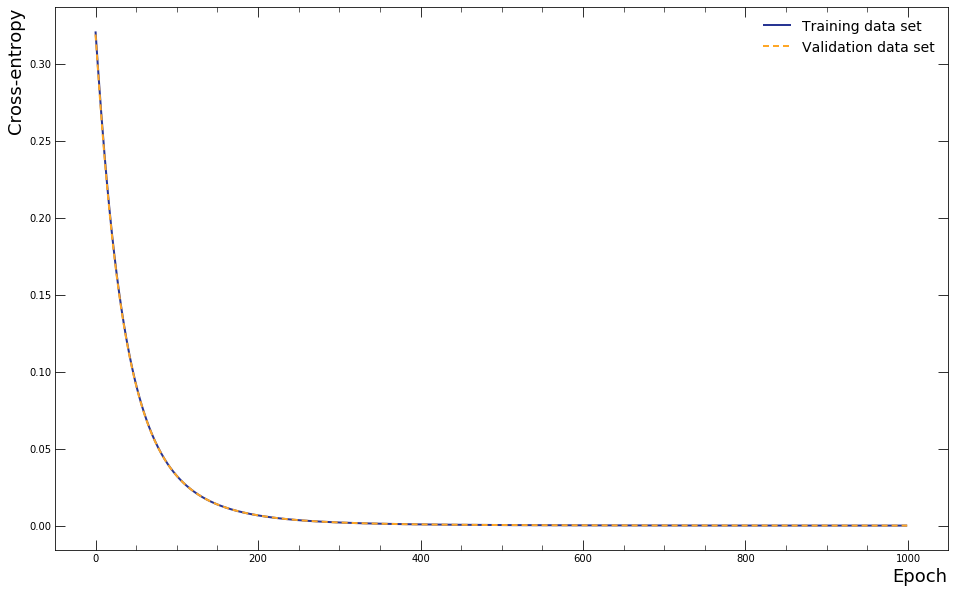

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

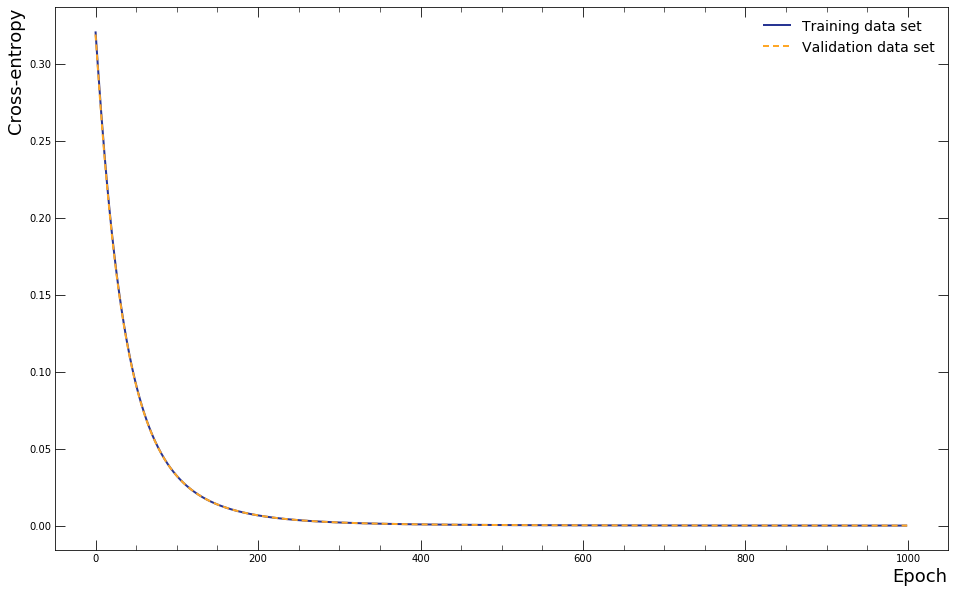

In [10]:
plot_loss(history)

## Training Set

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [12]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

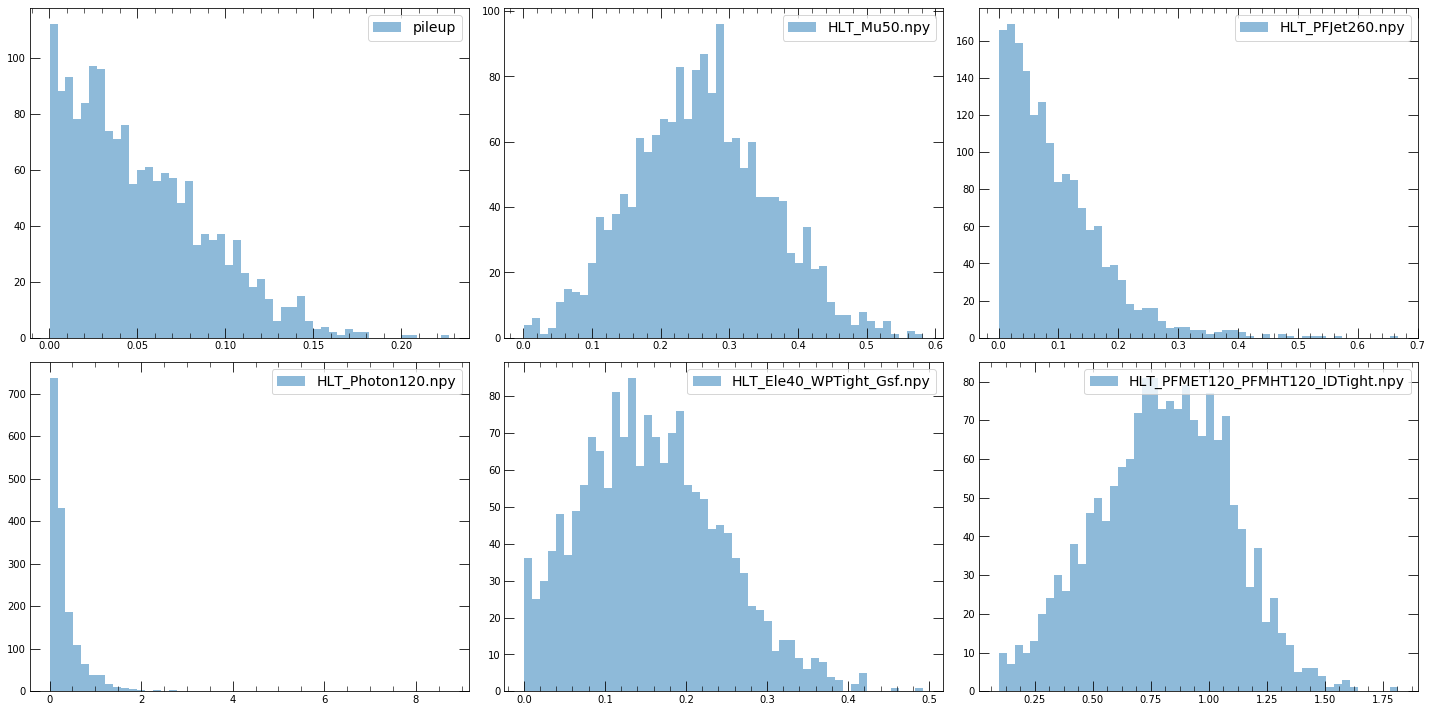

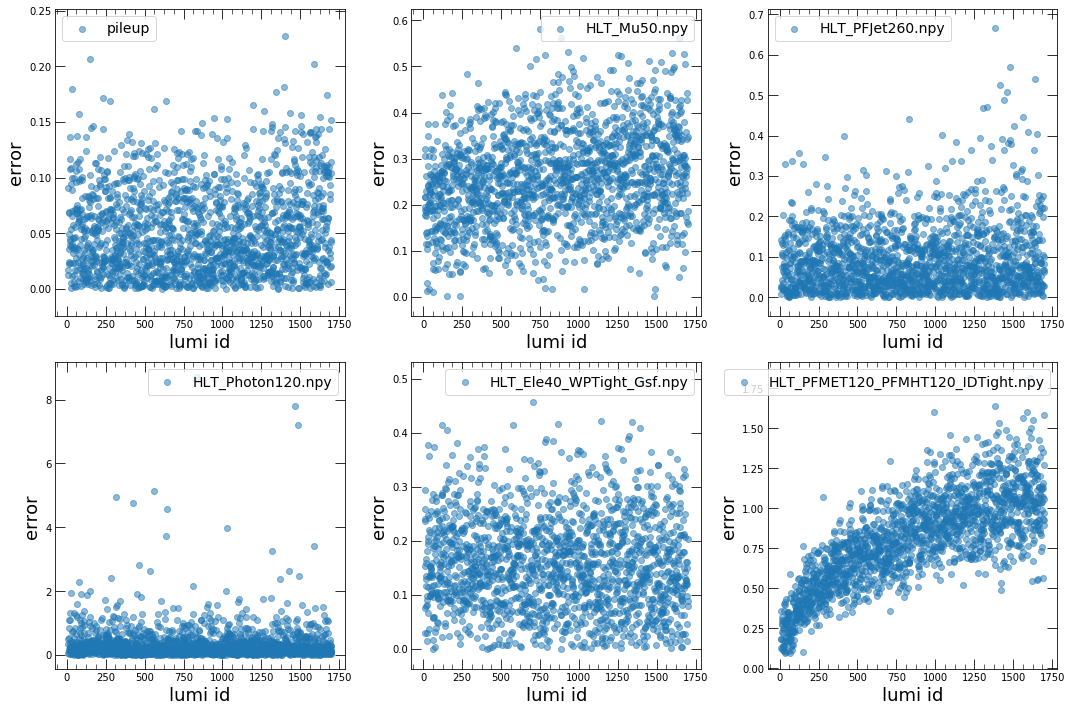

In [13]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

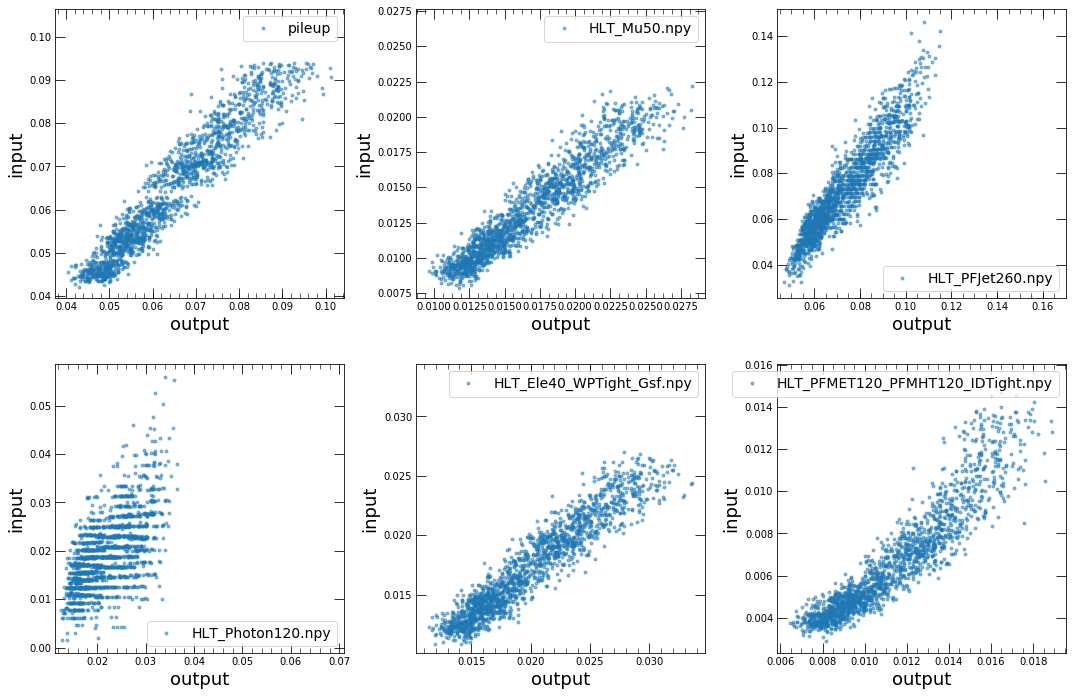

In [14]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Test Data

In [15]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [16]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

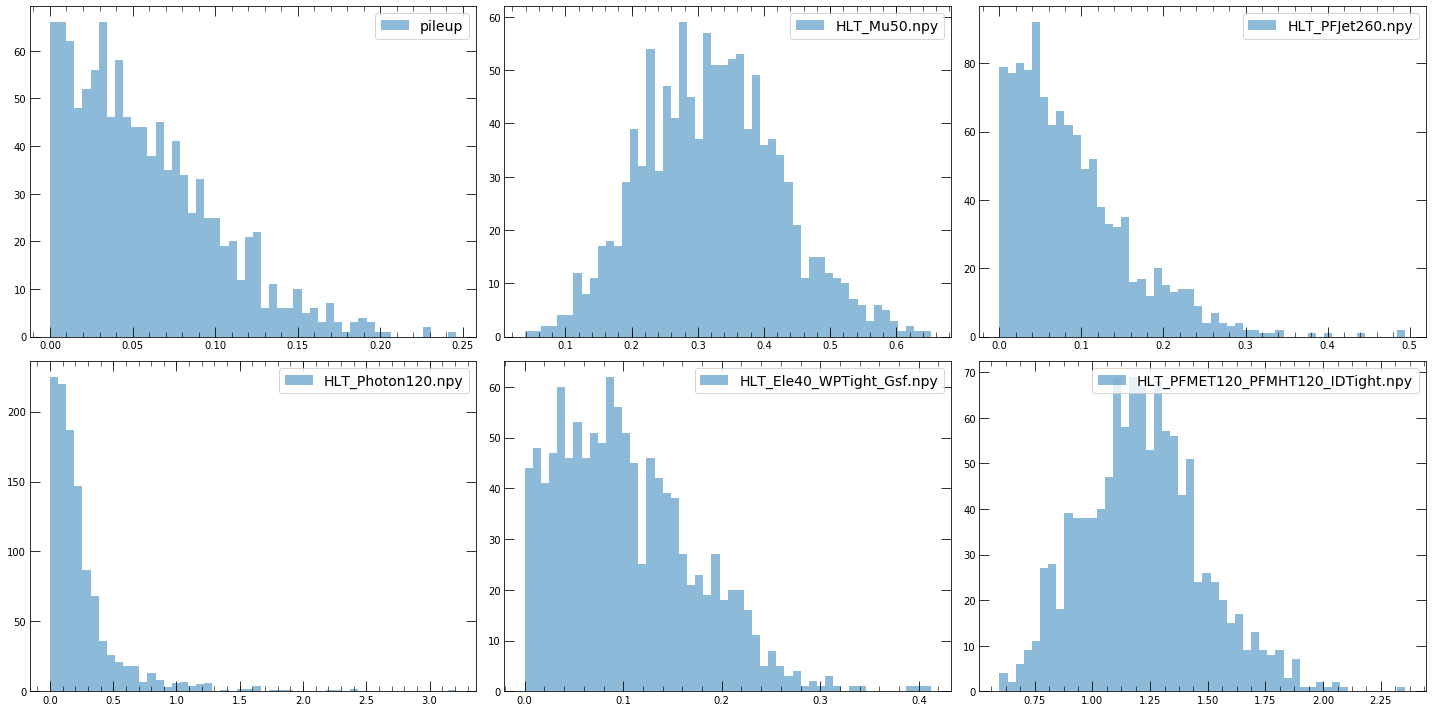

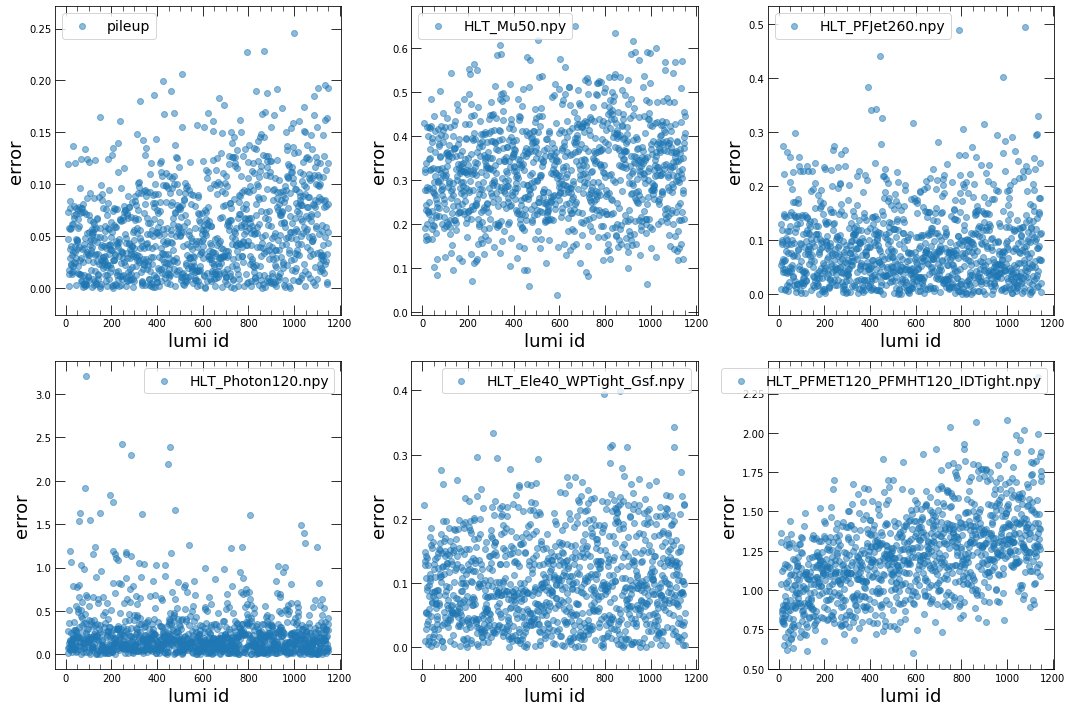

In [17]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

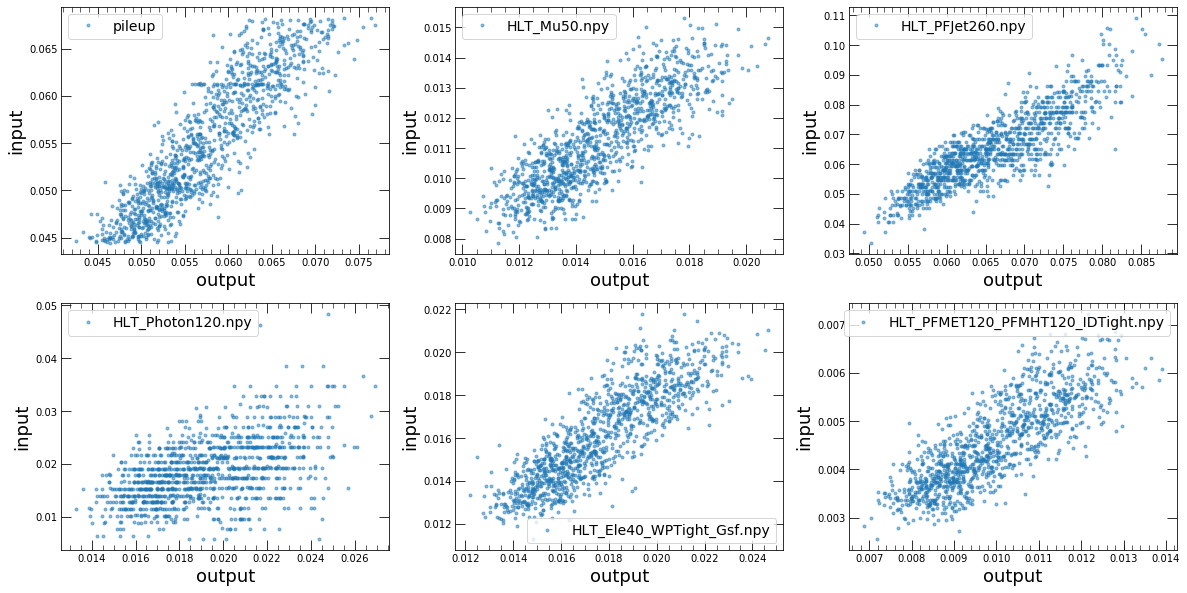

In [18]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [147]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [19]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [20]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [21]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

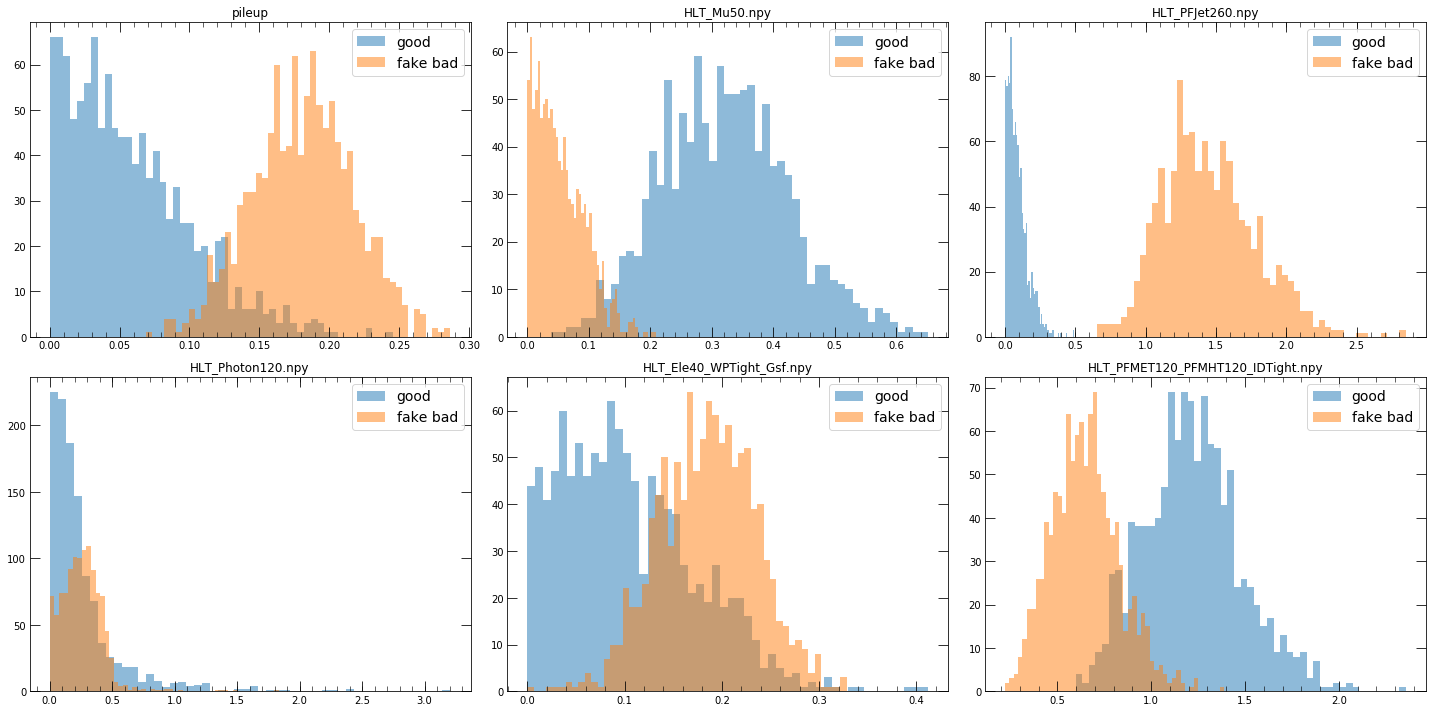

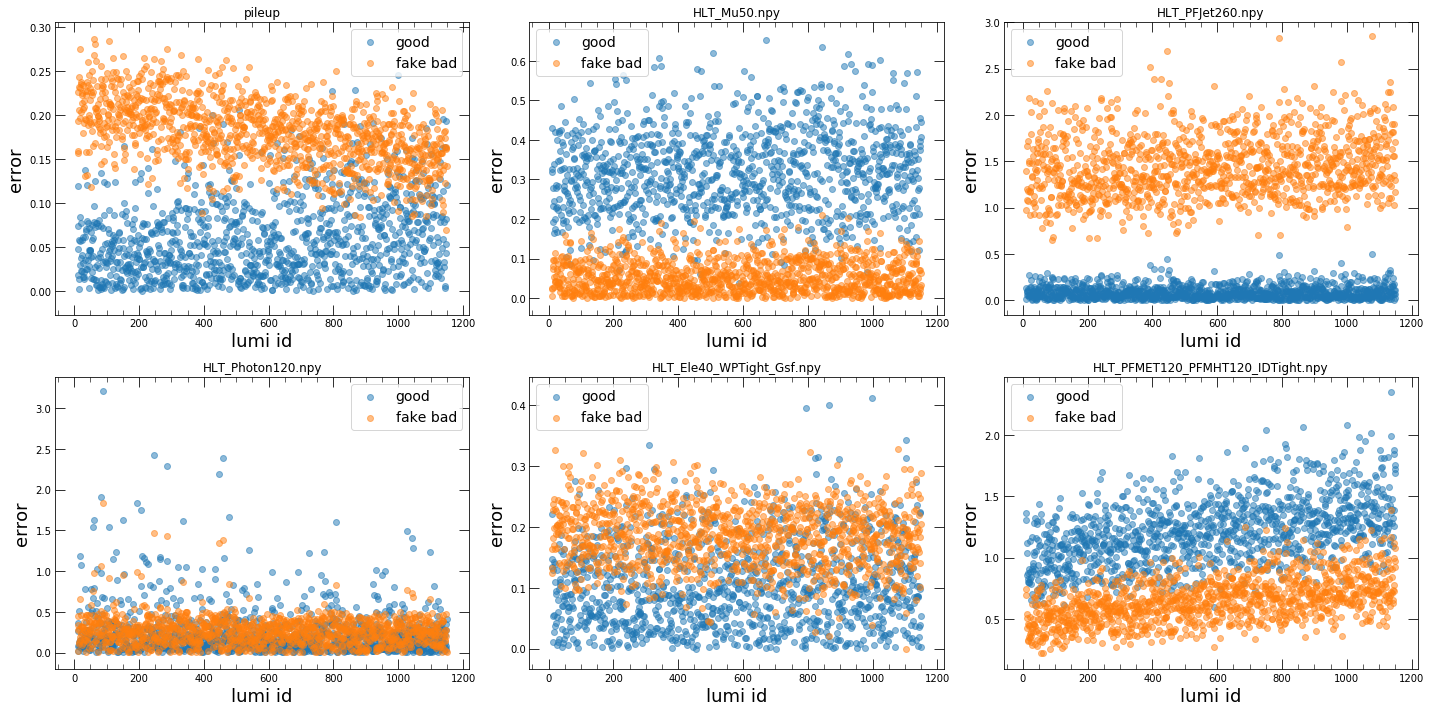

In [22]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

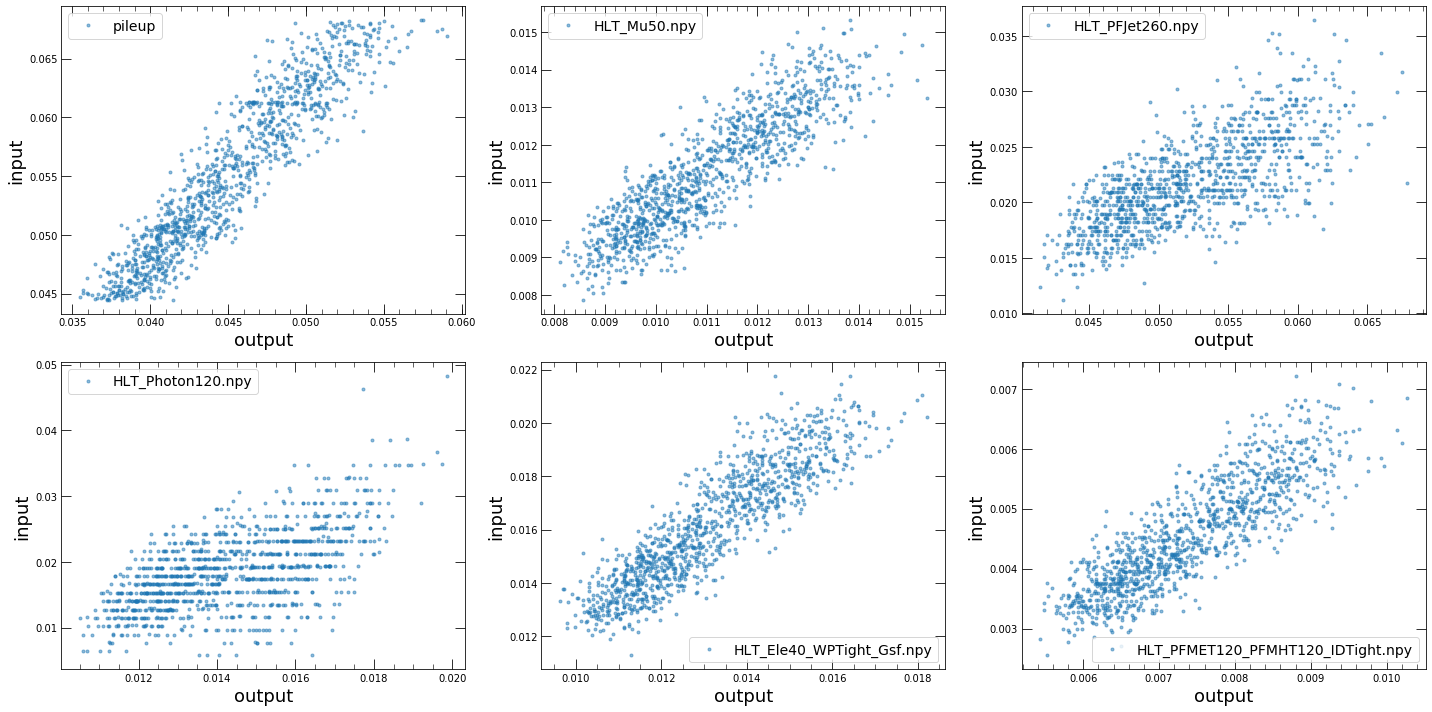

In [23]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [24]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [25]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [26]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [27]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [28]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


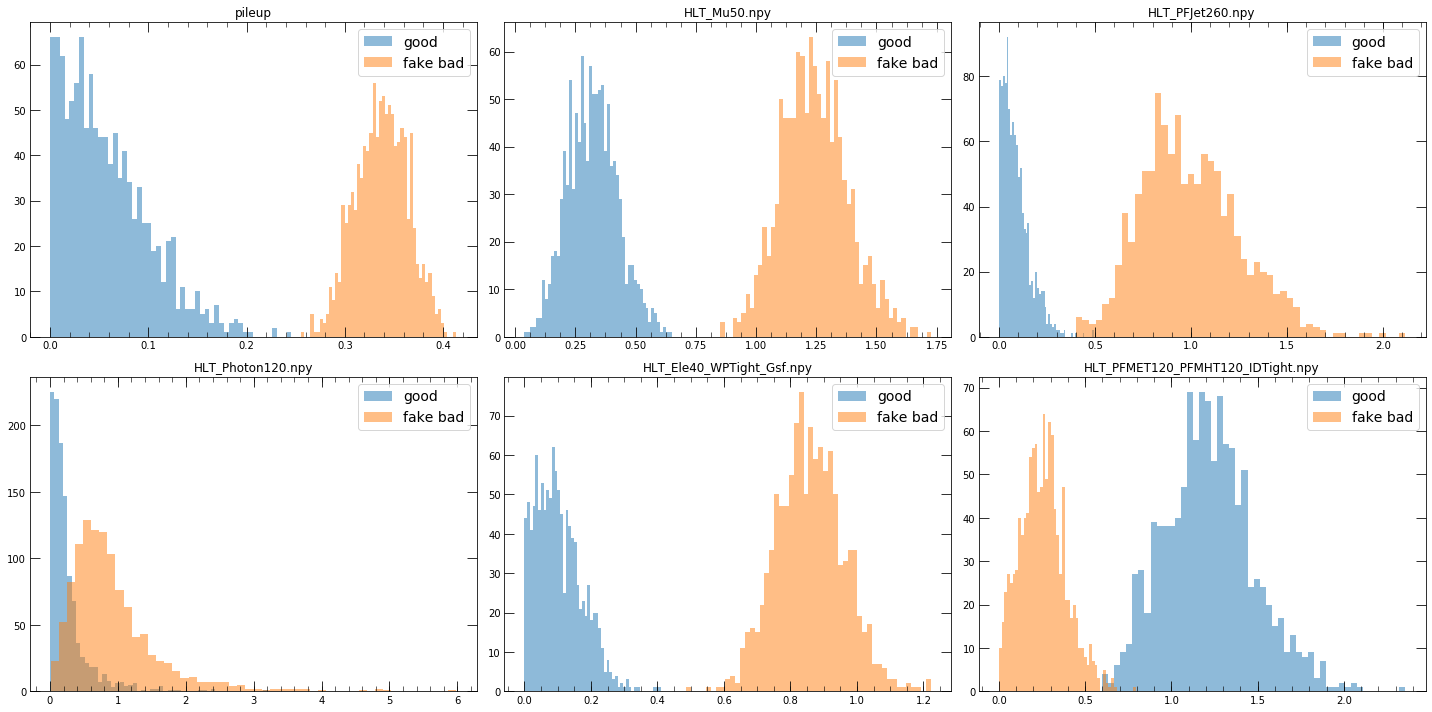

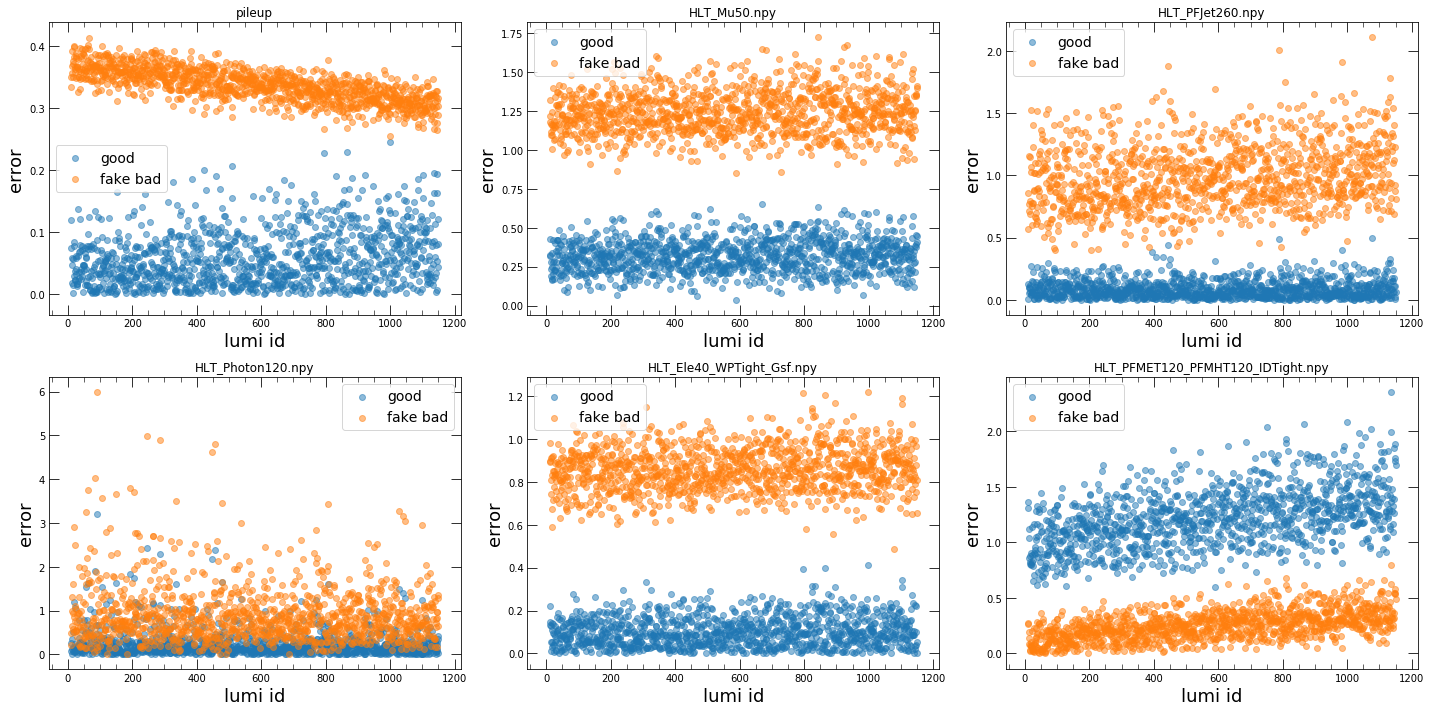

In [29]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

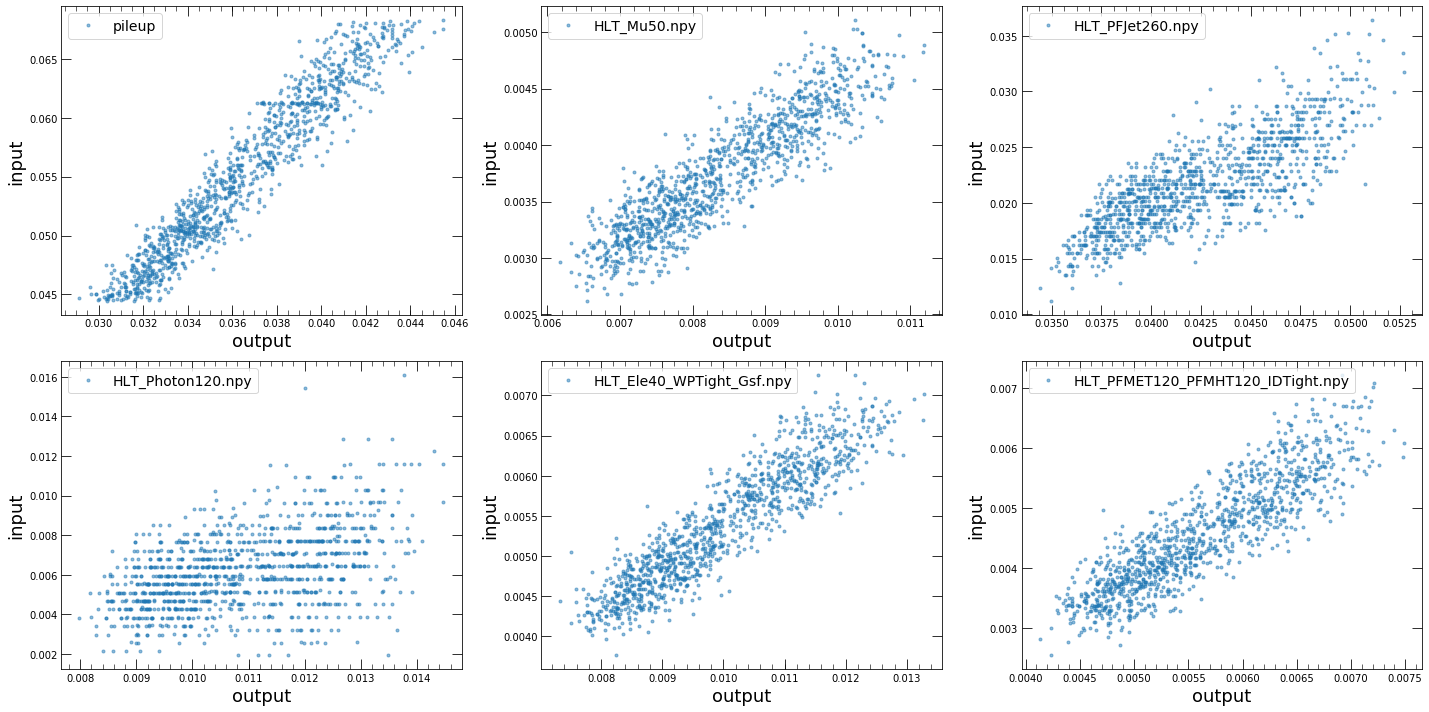

In [30]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [31]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [32]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [33]:
bad_runs = [301480]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [34]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

NameError: name 'WINDOW' is not defined

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Real Bad Data

In [ ]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [ ]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()